In [187]:
import os
import statistics
import csv
import itertools
import keras

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn

from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical
from keras.optimizers import Adam

In [79]:
act_path = "wisdm-dataset/activity_key.txt"
act_file = open(act_path,"r")
act_list = act_file.read().split('\n')
act_map = {}
for elem in act_list:
    split = elem.split(" = ")
    if len(split) < 2:
        continue
    act_map[split[1]] = split[0]
    
act_map

{'A': 'walking',
 'B': 'jogging',
 'C': 'stairs',
 'D': 'sitting',
 'E': 'standing',
 'F': 'typing',
 'G': 'teeth',
 'H': 'soup',
 'I': 'chips',
 'J': 'pasta',
 'K': 'drinking',
 'L': 'sandwich',
 'M': 'kicking',
 'O': 'catch',
 'P': 'dribbling',
 'Q': 'writing',
 'R': 'clapping',
 'S': 'folding'}

In [66]:
data_dir = '/Users/derekmccreight/Dev/HAR_Device/wisdm-dataset/raw/'

phone_data = os.path.join(data_dir, 'phone')
watch_data = os.path.join(data_dir, 'watch')

# bases = [(p_base, [(phone_accel,'phone_accel'), (phone_gyro,'phone_gyro')]), (w_base,[(watch_accel,'watch_accel'), (watch_gyro,'watch_gyro')])]
# data = {}

participants = [p.replace('_accel_phone.txt', '') for p in os.listdir(os.path.join(p_base, 'accel')) if p.startswith('data_')]

def sanitize_data(data):
    data['z'] = data['z'].apply(lambda x: x.replace(';',''))
    data[['x', 'y', 'z']] = data[['x', 'y', 'z']].astype(float)

combined_phone = []
combined_watch = []
for participant in tqdm(participants):
    data_types = itertools.product(['phone', 'watch'], ['accel', 'gyro'])
    phone_data = []
    watch_data = []
    for device, sensor in data_types:
        data_path = f'{participant}_{sensor}_{device}.txt'
        data = pd.read_csv(os.path.join(data_dir, device, sensor, data_path), header=None, names=['participant', 'activity', 't', 'x', 'y', 'z'])  
        sanitize_data(data)
        data = data.rename(columns={'x': f'{device}_{sensor}_x', 'y': f'{device}_{sensor}_y', 'z': f'{device}_{sensor}_z'})
        data = data.sort_values('t')
        l = phone_data if device == 'phone' else watch_data
        l.append(data)
    merged_phone = pd.merge_asof(phone_data[0], phone_data[1], on='t', by=['participant', 'activity'])
    merged_phone = merged_phone[~merged_phone.isnull().any(axis=1)].reset_index(drop=True)
    combined_phone.append(merged_phone)
    merged_watch = pd.merge_asof(watch_data[0], watch_data[1], on='t', by=['participant', 'activity'])
    merged_watch = merged_watch[~merged_watch.isnull().any(axis=1)].reset_index(drop=True)
    combined_watch.append(merged_watch)

In [194]:
phone = pd.concat(combined_phone)
watch = pd.concat(combined_watch)

In [195]:
phone.to_pickle('phone.df')
watch.to_pickle('watch.df')

## Phone Data

In [83]:
window_size = 100
stride = window_size

frames = []
for i in tqdm(range(0, len(phone)-window_size, stride)):
    window = phone.iloc[i:i+window_size]
    if window['activity'].nunique() == 1:
        frames.append(window)

In [117]:
phone_set = set(phone['t'])
watch_set = set(watch['t'])

In [118]:
phone_set.intersection(watch_set)

set()

In [85]:
activities = sorted(act_map.keys())
activity_encoding = {v: k for k, v in enumerate(activities)}

X_list = []
y_list = []

for frame in tqdm(frames):
    X_list.append(frame[['phone_accel_x', 'phone_accel_y', 'phone_accel_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']].values)
    y_list.append(activity_encoding[frame.iloc[0]['activity']])

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17}


In [88]:
X = np.array(X_list)
y = np.array(to_categorical(y_list))

In [90]:
print(X.shape)
print(y.shape)

(46906, 100, 6)
(46906, 18)


sandwich


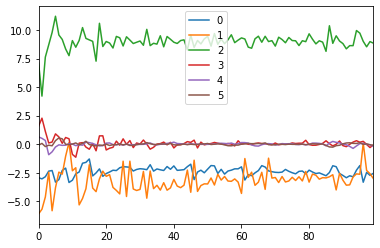

In [121]:
n = 16000
pd.DataFrame(X_list[n]).plot()

reverse_activity_encoding = {v: act_map[k] for k, v in activity_encoding.items()}
print(reverse_activity_encoding[y_list[n]])

In [126]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(28143, 100, 6)
(9381, 100, 6)
(9382, 100, 6)
(28143, 18)
(9381, 18)
(9382, 18)


In [156]:
model = Sequential()

model.add(Conv1D(16, 3, activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 98, 16)            304       
_________________________________________________________________
batch_normalization_40 (Batc (None, 98, 16)            64        
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 49, 16)            0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 47, 32)            1568      
_________________________________________________________________
batch_normalization_41 (Batc (None, 47, 32)            128       
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 23, 32)            0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 21, 64)          

In [157]:
model.compile(Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['acc'])

In [158]:
model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=1)

Train on 28143 samples, validate on 9381 samples
Epoch 1/20
28143/28143 [==============================] - 10s 368us/step - loss: 2.1352 - acc: 0.2769 - val_loss: 1.8770 - val_acc: 0.3373
Epoch 2/20
28143/28143 [==============================] - 9s 331us/step - loss: 1.8036 - acc: 0.3694 - val_loss: 1.6430 - val_acc: 0.4223
Epoch 3/20
28143/28143 [==============================] - 9s 332us/step - loss: 1.6544 - acc: 0.4160 - val_loss: 1.5676 - val_acc: 0.4439
Epoch 4/20
28143/28143 [==============================] - 9s 334us/step - loss: 1.5466 - acc: 0.4546 - val_loss: 1.5434 - val_acc: 0.4475
Epoch 5/20
28143/28143 [==============================] - 9s 331us/step - loss: 1.4814 - acc: 0.4743 - val_loss: 1.4188 - val_acc: 0.5068
Epoch 6/20
28143/28143 [==============================] - 9s 332us/step - loss: 1.4098 - acc: 0.4971 - val_loss: 1.3938 - val_acc: 0.5047
Epoch 7/20
28143/28143 [==============================] - 9s 335us/step - loss: 1.3481 - acc: 0.5216 - val_loss: 1.3545 - 

In [189]:
y_val_pred = model.predict(X_val)

y_val_argmax = y_val.argmax(axis=1)
y_val_pred_argmax = y_val_pred.argmax(axis=1)

actual_val_activities = [reverse_activity_encoding[i] for i in y_val_argmax]
predicted_val_activities = [reverse_activity_encoding[i] for i in y_val_pred_argmax]

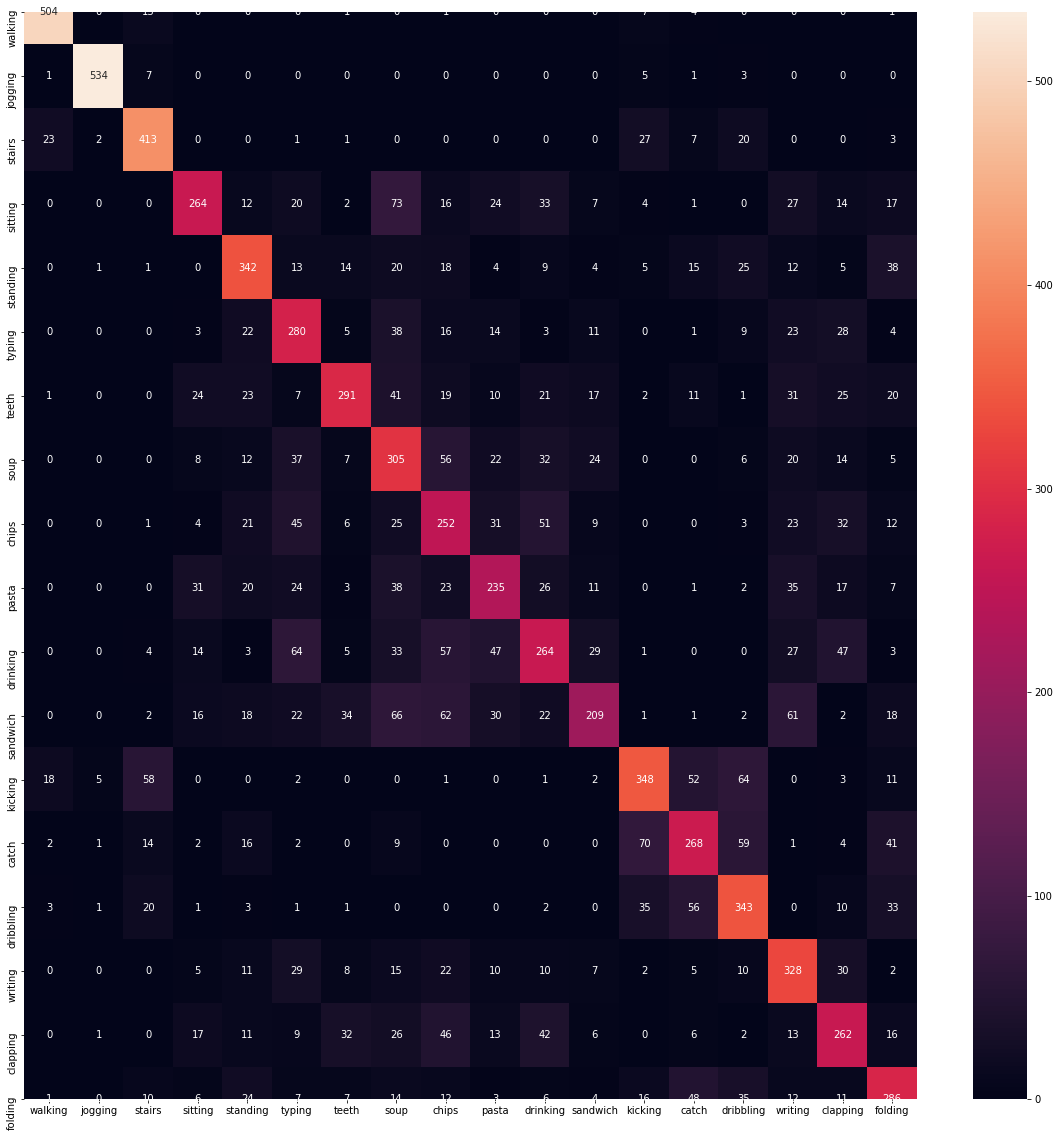

In [193]:
cm = confusion_matrix(y_val_argmax, y_val_pred_argmax)
df_cm = pd.DataFrame(cm, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (20,20))
sn.heatmap(df_cm, annot=True, fmt='g')